<a href="https://colab.research.google.com/github/au1206/Fine_Tuning_BERT/blob/main/Fine_Tune_BERT_for_Text_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Fine-Tune BERT for Text Classification with TensorFlow</h1>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1mBqrfxng42SgSXvK62V1C67Or_vgrsVm' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

We will be using Google Colab for this tutorial as we would require a GPU to fine-tune BERT.

## Prerequisites:
- Willingness to learn: Growth Mindset is all you need 
- Some basic idea about Tensorflow/Keras and BERT
- Some Python to follow along with the code

## Initial Set Up

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


Cloning the Github Repo for tensorflow models 
-  –depth 1, during cloning, Git will only get the latest copy of the relevant files. It can save you a lot of space and time.

- -b lets us clone a specific branch only.

**Please match it with your tensorflow 2.x version.**

In [3]:
!git clone --depth 1 -b v2.5.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 958, done.
remote: Counting objects: 100% (958/958), done.
remote: Compressing objects: 100% (784/784), done.
remote: Total 958 (delta 247), reused 339 (delta 161), pack-reused 0
Receiving objects: 100% (958/958), 1.49 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Note: checking out '4f0e20f26d79610b7dbcf4c103dbd53c456a8348'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards also ignore any ERRORS popping up at this step

     |████████████████████████████████| 7.3MB 5.0MB/s 
     |████████████████████████████████| 194kB 37.3MB/s 
     |████████████████████████████████| 15.3MB 208kB/s 
     |████████████████████████████████| 9.9MB 32.0MB/s 
     |████████████████████████████████| 296kB 46.6MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 27.4MB 141kB/s 
     |████████████████████████████████| 174kB 50.2MB/s 
     |████████████████████████████████| 3.9MB 29.9MB/s 
     |████████████████████████████████| 686kB 40.1MB/s 
     |████████████████████████████████| 358kB 50.6MB/s 
     |████████████████████████████████| 10.3MB 26.8MB/s 
     |████████████████████████████████| 645kB 39.1MB/s 
     |████████████████████████████████| 38.2MB 81kB/s 
     |████████████████████████████████| 3.0MB 25.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.2MB 42.4MB/s 
     |████████████████████████████████| 61kB 7.5MB/s

**Note**: After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu ---> Runtime ---> Restart runtime...)

**NOTE: ANYTHING BEFORE THIS CELL SHOULD ONLY BE RUN ONCE, ONLY DURING THE INITIAL SETUP**

## Some Initial Imports and Checks

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


##Lets Get the Dataset

- The data we will use is the dataset provided on the [Quora Insincere Questions Classification competition on Kaggle](https://www.kaggle.com/c/quora-insincere-questions-classification/data). 

- Please feel free to download the train set from kaggle or use the link below to download the train.csv from that competition [https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip](https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip). 

- Let us decompress and read the data into a pandas DataFrame.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/quora_dataset_train.csv/quora_dataset_train.csv.zip', 
                 compression='zip',
                 low_memory=False)
print(df.shape)

(1306122, 3)


In [4]:
df.head(10)
# label 0 == non toxic
# label 1 == toxic 

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


### Get to Know your data: Some Basic EDA

0    1225312
1      80810
Name: target, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

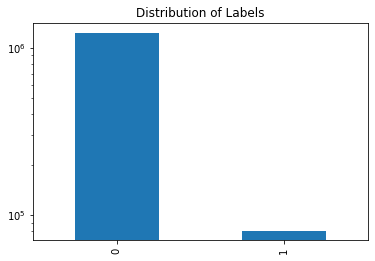

In [5]:
print(df['target'].value_counts())
df['target'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')

In [6]:
print('Average word length of questions in dataset is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in dataset is {0:.0f}.'.format(np.max(df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in dataset is {0:.0f}.'.format(np.mean(df['question_text'].apply(lambda x: len(x)))))

Average word length of questions in dataset is 13.
Max word length of questions in dataset is 134.
Average character length of questions in dataset is 71.


In [7]:
# Since the dataset is very imbalanced we will keep the same distribution in both train and test set by stratifying it based on the labels
# using small portions of the data as the over all dataset would take ages to train, feel free to include more data by changing train_size 
train_df, remaining = train_test_split(df, random_state=42, train_size=0.05, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.005, stratify=remaining.target.values)
print(train_df.shape)
print(valid_df.shape)

(65306, 3)
(6204, 3)


In [8]:
print("FOR TRAIN SET\n")
print('Average word length of questions in train set is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in train set is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in train set is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Label Distribution in train set is \n{}.'.format(train_df['target'].value_counts()))
print("\n\nFOR VALIDATION SET\n")
print('Average word length of questions in valid set is {0:.0f}.'.format(np.mean(valid_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in valid set is {0:.0f}.'.format(np.max(valid_df['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in valid set is {0:.0f}.'.format(np.mean(valid_df['question_text'].apply(lambda x: len(x)))))
print('Label Distribution in validation set is \n{}.'.format(valid_df['target'].value_counts()))

FOR TRAIN SET

Average word length of questions in train set is 13.
Max word length of questions in train set is 56.
Average character length of questions in train set is 71.
Label Distribution in train set is 
0    61266
1     4040
Name: target, dtype: int64.


FOR VALIDATION SET

Average word length of questions in valid set is 13.
Max word length of questions in valid set is 56.
Average character length of questions in valid set is 71.
Label Distribution in validation set is 
0    5820
1     384
Name: target, dtype: int64.


So Looks like the train and validation set a re similar in terms of class imbalance and the various lengths in the question texts

Text(0.5, 1.0, 'Distribution of question text length in words')

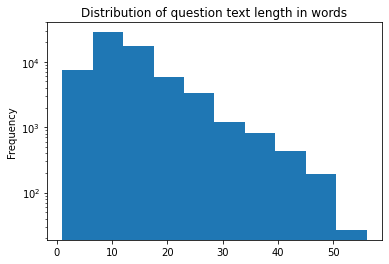

In [9]:
# TRAIN SET 
train_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

Text(0.5, 1.0, 'Distribution of question text length in words')

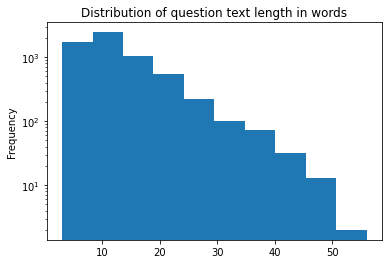

In [10]:
# VALIDATION SET
valid_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

Text(0.5, 1.0, 'Distribution of question text length in characters')

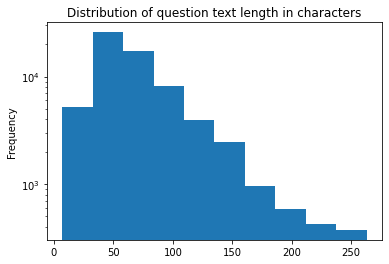

In [11]:
# TRAIN SET
train_df['question_text'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

Text(0.5, 1.0, 'Distribution of question text length in characters')

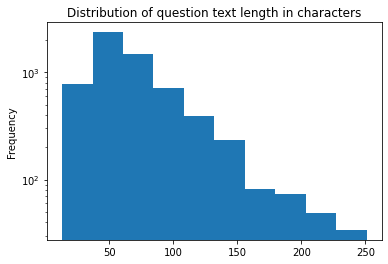

In [12]:
# VALIDATION SET
valid_df['question_text'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

Even the distribution of question length in words and characters is very similar, looks like a good train test split so far

# Taming the Data

In [42]:
# we want the dataset to be created and processed on the cpu 
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
  # lets look at 3 samples from train set
  for text,label in train_data.take(3):
    print(text)
    print(label)
  

tf.Tensor(b'Which are the top drones for shooting a high enough quality video to be used in a small business advertisement (midrange budget ad)?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'What are some good books you recommend on raising a good child with morals and values?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'How do you do your make up for special occasions?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Lets BERT: Get the Pre-trained BERT Model from TensorFlow Hub

We will be using the uncased BERT present in the tfhub, in order the prepare the text to be given to the BERT layer.
We need to first tokenize the words, the tokenizer here is present as an model asset and will do uncasing for us as well 

In [43]:
# Setting some parameters

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

In [44]:
# Get BERT layer and tokenizer:
# All details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

### Checking out some of the training samples and their tokenized ids

In [45]:
input_string = "hello world, it is a wonderful day for learning"
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))

['hello', 'world', '##,', 'it', 'is', 'a', 'wonderful', 'day', 'for', 'learning']
[7592, 2088, 29623, 2009, 2003, 1037, 6919, 2154, 2005, 4083]


## Lets Get That Data Ready: Tokenize and Preprocess Text for BERT


Each line of the dataset is composed of the review text and its label.
Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids/input_type_ids

- **Input Word Ids:** Output of out tokenizer, converitng each sentence into set of token ids.

- **Input Masks:** Since we are padding all the sequences to 128(max sequence length) , its important that we create some sort of a mask to make sure those paddings do not interfere therefore we need a generate input mask blocking the paddings, The mask has 1 for real tokens and 0 for padding tokens. Only real
tokens are attended to.

- **Segment Ids:** For out task of text classification, Since there is only one sequence, the segment_ids/input_type_ids is basically just a vector of 0s 



Bert was trained on 2 tasks:
- fill in randomly masked words from a sentence.
- given 2 sentences which came first. 



In [46]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier

def create_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  """
  converts the datapoint into usable features for BERT using the classifier_data_lib

  Parameters:
    text: Input text string
    lable: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

  Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

  """
  # since we only have 1 sentence for classification purpose, textr_b is None
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  # since only 1 example, the index=0
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

### Wrapping the Python Function into a TensorFlow op for Eager Execution

In [47]:
def create_feature_map(text, label):
  """
  A tensorflow function wrapper to apply the transformation on the dataset.
  Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

  Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
  """
  input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

  # the final datapoint passed to the model is of the format a dictionary as x and labels.
  # the dictionary have keys which should obv match

## Let the Data Flow: Creating the final input pipeline using `tf.data`

In [48]:
# Now we will simply apply the transformation to our train and test datasets
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [49]:
# train data spec, we can finally see the input datapoint is now converted to the BERT specific input tensor
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [50]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Lets Model Our Way to Glory!!!

## Create The Model

There are two outputs from the BERT Layer: 
- A pooled_output of shape [batch_size, 768] with representations for the entire input sequences  
- A sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).

For the classificaiton we are only concerned with the pooled_output

In [51]:
# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  # for classification we only care about the pooled-output
  # at this point we can play around with the classification head based on the downstream tasks and its complexity
  
  drop = tf.keras.layers.Dropout(0.5)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

  # inputs coming from the function
  model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)
  
  return model
  

## Let Us Train !

In [52]:
# Calling the create model function to get teh keras based functional model
model = create_model()

In [53]:
# using adam with a lr of 2*(10^-5), loss as binary cross entropy as only 2 classes and similarly binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

One drawback of the tf hub is that we import the entire module as a layer in keras as a result of which we dont see the parameters and layers in the model summary.

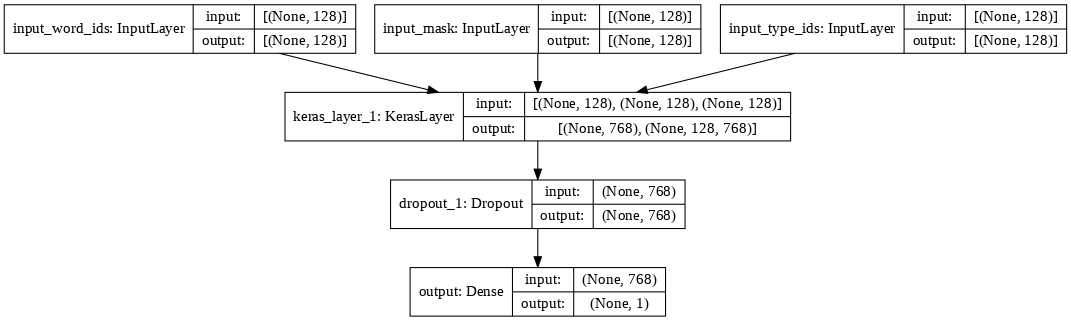

In [54]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

The official tfhub page states that
"All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice." Therefore we will go ahead and train the entire model without freezing anything

In [55]:
# Train model
# setting low epochs as It starts to overfit with this limited data, please feel free to change
epochs = 5
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/5
2040/2040 [==============================] - 1703s 829ms/step - loss: 0.1271 - binary_accuracy: 0.9510 - val_loss: 0.1031 - val_binary_accuracy: 0.9594
Epoch 2/5
2040/2040 [==============================] - 1717s 841ms/step - loss: 0.0807 - binary_accuracy: 0.9672 - val_loss: 0.1306 - val_binary_accuracy: 0.9548
Epoch 3/5
2040/2040 [==============================] - 1718s 842ms/step - loss: 0.0433 - binary_accuracy: 0.9843 - val_loss: 0.1576 - val_binary_accuracy: 0.9556
Epoch 4/5
2040/2040 [==============================] - 1693s 829ms/step - loss: 0.0235 - binary_accuracy: 0.9920 - val_loss: 0.2412 - val_binary_accuracy: 0.9535
Epoch 5/5
2040/2040 [==============================] - 1718s 842ms/step - loss: 0.0151 - binary_accuracy: 0.9948 - val_loss: 0.2421 - val_binary_accuracy: 0.9550


### Lets Look at some Graphs

These Graphs will mainly be useful when we are training for more epochs and more data

In [56]:

def create_graphs(history):
    train_accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy'],
    train_losses = history.history['loss'],
    val_losses = history.history['val_loss']
    fig1 = plt.figure()
    plt.plot(train_accuracy, 'r', linewidth=3.0, marker='o')
    plt.plot(val_accuracy, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.show()

    fig2 = plt.figure()
    plt.plot(train_losses, 'r', linewidth=3.0, marker='o')
    plt.plot(val_losses, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

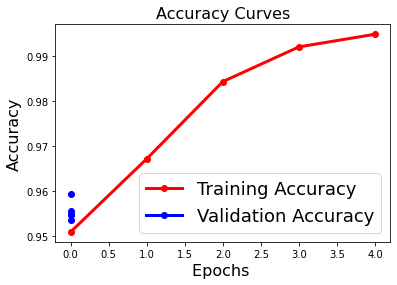

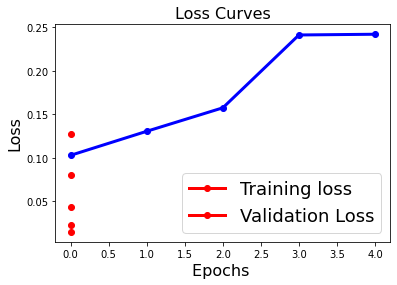

In [57]:
create_graphs(history)

Hopefully This was useful for you and by now you have a small kickstart on training and utilizing BERT for a variety of downstream tasks like classification, Named Entity Recognition, Sentence filling and many more.

You can check out and get the entire code in a form of notebook and also run it on colab from this [Github Repo](https://github.com/au1206/Fine_Tuning_BERT)

If this was helpful consider sharing it with more people so thay can also learn about it...

Coming up Next:
- BERT Annotated Paper
- Write up on Transformers and its workings 